In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

def plot_confusion_matrix(ytrue, yhat):
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    labels = ['admission', 'no admission']
    result = confusion_matrix(ytrue, yhat)
    fig = plt.figure(figsize=(8,6))
    ax = sns.heatmap(result, annot=True, cmap=cmap)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.show()

def categorial_to_numerical(df, cols):
    for col in cols:
        tmp= pd.get_dummies(df[col], prefix=col)
        df = df.join(tmp)
    return df.drop(columns=cols)

In [2]:
df_admission = pd.read_csv('admissions.csv')
df_score = pd.read_csv('scores.csv')
df_member = pd.read_csv('members.csv')

df_admission_count = pd.DataFrame(df_admission.id.value_counts()).reset_index()
df_admission_count.columns = ['id', 'counts']

df = df_member.merge(df_score, on='id', how='left').merge(df_admission_count, on='id', how='left')
df.counts = df.counts.fillna(0)
df = shuffle(df)

cat_cols = ['gender', 'race']
df = categorial_to_numerical(df, cat_cols)

df['admission'] = df.counts.apply(lambda x: True if x!=0 else False)

cols_to_drop = ['dob', 'zip_code', 'name', 'counts', 'id']
df = df.drop(columns=cols_to_drop)

# just save 1/5 of the original data, and start from there
df_admission_true = df[df.admission==True]
df_admission_false = df[df.admission==False]

n = int(0.2*df_admission_true.shape[0])

all_idx = np.arange(df_admission_true.shape[0])
np.random.shuffle(all_idx)
idx_test = all_idx[:n]
df_admission_true_test = df_admission_true.iloc[idx_test, :]

all_idx = np.arange(df_admission_false.shape[0])
np.random.shuffle(all_idx)
idx_test = all_idx[:n]
df_admission_false_test = df_admission_false.iloc[idx_test, :]

df_test = pd.concat([df_admission_false_test, df_admission_true_test], axis=0)

df_train = df.loc[~df.index.isin(df_test.index), :]

# CFO: who is likely to be admitted
As the CFO I would like to be able to predict which members are likely to be admitted
into the hospital, this would allow us to prioritize outreach to those members and
support them in the home in order to avoid future hospital stays.

In [4]:
df_admission_true = df_train[df_train.admission==True]
df_admission_false = df_train[df_train.admission==False]
df_admission_false = shuffle(df_admission_false)
df_admission_false_resampled = df_admission_false[:df_admission_true.shape[0]]
df_train_resampled = pd.concat([df_admission_true, df_admission_false_resampled], axis=0)
df_train_resampled = shuffle(df_train_resampled)

y = df_train_resampled['admission']
X = df_train_resampled.drop(columns=['admission'])
feature_cols = X.columns.tolist()
transformer = StandardScaler()
transformer.fit(X)
X = transformer.transform(X)

params = {
    'max_depth': 3,
    'learning_rate': 0.04,
    'booster': 'gbtree',
    'n_estimator': 1000
}

xgb = XGBClassifier(**params)

xval_scores = cross_validate(xgb, X, y, cv=5, scoring=['accuracy','precision','recall'])

xval_scores

{'fit_time': array([0.07599783, 0.06400108, 0.05899978, 0.06200194, 0.06400084]),
 'score_time': array([0.01200104, 0.00999832, 0.00999975, 0.0100255 , 0.00999975]),
 'test_accuracy': array([0.84466019, 0.85679612, 0.83495146, 0.85679612, 0.87378641]),
 'test_precision': array([0.84466019, 0.86934673, 0.81363636, 0.88082902, 0.87019231]),
 'test_recall': array([0.84466019, 0.83980583, 0.86893204, 0.82524272, 0.87864078])}

In [5]:
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.04, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimator=1000, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [224]:
ytest = df_test['admission']
Xtest = df_test.drop(columns=['admission'])

Xtest = transformer.transform(Xtest)

yhat = xgb.predict(Xtest)

print('accuracy score: {}'.format(accuracy_score(ytest, yhat)))
print('precision score: {}'.format(precision_score(ytest, yhat)))
print('recall score: {}'.format(recall_score(ytest, yhat)))

accuracy score: 0.8599221789883269
precision score: 0.8413284132841329
recall score: 0.8871595330739299


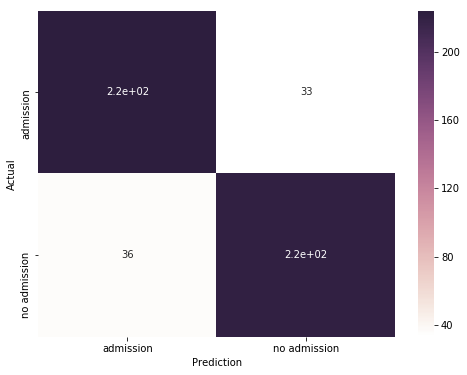

In [182]:
plot_confusion_matrix(ytest, yhat)

# VP of Life Management: what factor contributes to admission
As the VP of Life Management I to understand what factors contribute to hospital
admissions, this would help our life managers understand our members more deeply
and provide personal care plans for each member.

## Method 1

In [183]:
sorted_idx = np.argsort(xgb.feature_importances_)

In [184]:
sorted_col = [feature_cols[i] for i in sorted_idx]
sorted_feature_importance = [xgb.feature_importances_[i] for i in sorted_idx]

<BarContainer object of 17 artists>

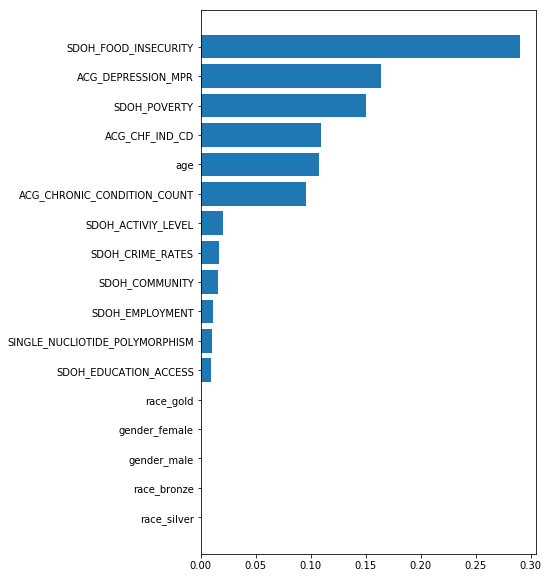

In [185]:
plt.figure(figsize=(6,10))
plt.barh(sorted_col, sorted_feature_importance)

## Method 2
Here Shapley value is used for feature ranking. Shapley value is from game theory, it indicates the contribution of each data points to the final average prediction.

below is an example of Shapley value using XGBoost.
- the color bar indicates the relative place of a value in a single column.
- x axis is the shapley value, calculated for each data point
- the position of each data point shows its contribution to the prediction: negative means it drives the prediciton down and positive means it drives the prediction up
- the sequence (top down) shows the magnitude of each feature to the prediction

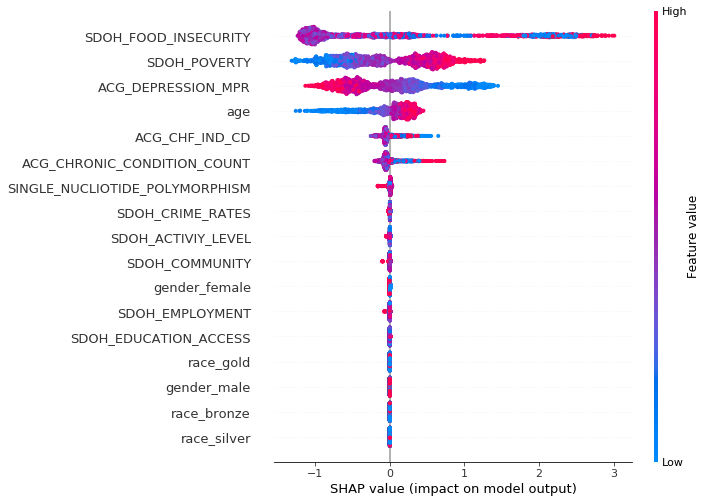

In [8]:
import shap

y = df_train_resampled['admission']
X = df_train_resampled.drop(columns=['admission'])

params = {
    'max_depth': 3,
    'learning_rate': 0.04,
    'booster': 'gbtree',
    'n_estimator': 1000
}

xgb = XGBClassifier(**params)
xgb.fit(X,y)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

# VP of Life Management: what characteristics of people with high admission rate 
I would like to understand the members that have the
most hospital admissions.

In [193]:
df = df_member.merge(df_score, on='id', how='left').merge(df_admission_count, on='id', how='left')
df_admission_true_all = df[~df.counts.isnull()]

In [212]:
max_count = max(df_admission_true_all.counts)
df_admission_max = df_admission_true_all[df_admission_true_all.counts>=max(df_admission_true_all.counts)-4]
df_admission_others = df_admission_true_all[df_admission_true_all.counts<max(df_admission_true_all.counts)-4]

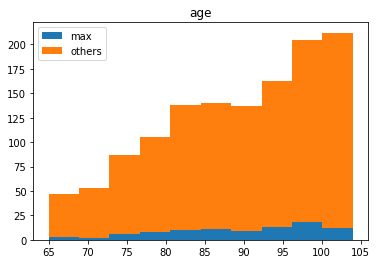

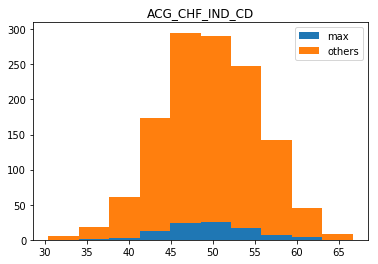

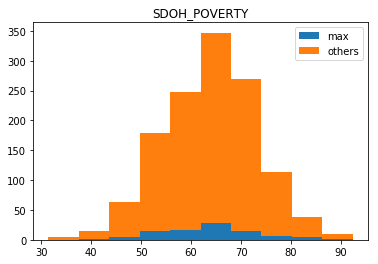

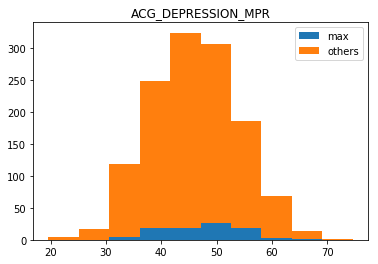

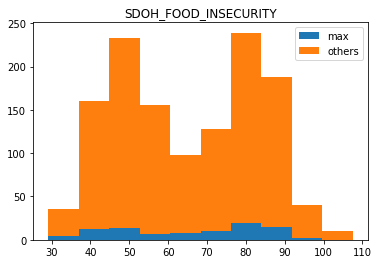

In [214]:
for col in sorted_col[-5:]:
    plt.hist([df_admission_max[col],df_admission_others[col]], label=['max','others'], stacked=True)
    plt.title(col)
    plt.legend()
    plt.show()

# Summary
## General
- two methods are used to resample majority class to balance the dataset. Results (accuracy, recall, precision) do not show siginificant difference. Some other methods are also available (for example, imbalanced-learn package offers many methods, such as generating synthetic data points to boost minority counts, method like this should be used with caution)

## Question 1
- This question is transformed to be a classification problem, that is, given the existing data, can we tell which client is more likely to be admitted to hospital. XGBoost is used for this problem. Advantages of using XGBoost over other methods:
    - Fast. XGBoost is very efficient compared to other algorithms such as random forest, SVM, or neural net. 
    - High accuracy. XGBoost can usually produce really good result without much hyperparameter tuning. 
    - It almost never overfits. While overfitting could be a big issue for other algorithms, XGBoost almost never overfits as long as the weak learner does not overfit.
  
  Of course, XGBoost is not perfect. Some disadvantages are:
    - It does not extrapolate well. XGBoost is basically a tree model. For all tree models, they have difficulty extrapolate what they learn from training data to testing data, if data points in testing fall outside the scope of training data, they do not have the capability to extrapolate.
- Without knowing which one is more important to reduce: false positive or false negative, it is difficult to find THE metrics to evaluate model performance. So in this project, I use precision, recall and accuracy. Some other metrics, like ROC and f1 score, can also be used for different purposes.
- precision, accuracy, and recall are quite consistent for both cross-validation and evaluation, all are around 85%. For future study, the effort can be spent on reducing false postive or false negative, or both, once more domain knowledge is obtained.

## Question 2
This question boils down to which feature has more importance in the model. It is pretty straightforward, but the observation is quite intersting.

- Food insecurity is the top 1 factor that determines whether a person is admitted to hospital, followed by depression, poverty and age. It shows that both physical reasons (age, food, and poverty) and mental reason (depression) have significant contribution to hospital admission
- Features that almost have no effect on hospital admission include gender, race and education.

Shapley value plots suggest the same.

## Question 3
This quetion asks the characteristics of the person with highest admission, compared to other patients. However the highest number of admission is 10, and there is only one person. So I relax the condition to top 5 highest admissions, which accounts for number of admission higher than 6. 

The value is then plotted against other patients with at least 1 admission. For age, depression and food insecurity, people with high admission rate tend to stay on the higher end of the spectrum.